<a href="https://colab.research.google.com/github/melihkurtaran/MachineLearning/blob/main/InstanceBasedLearning/InstancebasedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instance-based Learning Project**

In [1]:
!pip install cvxpy # download cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
#Import Libraries
import numpy as np
import pandas as pd
from sklearn import svm
import cvxpy as cp
from cvxopt import matrix, solvers
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

In [3]:
#Connect to GitHub for faster access
!git clone https://github.com/melihkurtaran/MachineLearning.git

Cloning into 'MachineLearning'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 100 (delta 51), reused 43 (delta 17), pack-reused 0
Receiving objects: 100% (100/100), 4.04 MiB | 15.43 MiB/s, done.
Resolving deltas: 100% (51/51), done.


My group number is 9

In [4]:
#Reading the files

#for task 1
ds1 = pd.read_csv('MachineLearning/InstanceBasedLearning/ds091.txt', sep=" ", header=None, index_col=False, skiprows=1)

#for task 2
ds2 = pd.read_csv('MachineLearning/InstanceBasedLearning/ds092.txt', sep=" ", header=None, index_col=False, skiprows=1)

#for task 3
ds3tr = pd.read_csv('MachineLearning/InstanceBasedLearning/ds093tr.txt', sep=" ", header=None, index_col=False, skiprows=1)
ds3te = pd.read_csv('MachineLearning/InstanceBasedLearning/ds093te.txt', sep=" ", header=None, index_col=False, skiprows=1)

# **T1**

In [5]:
ds1.loc[ds1[2] == 0, 2] = -1

In [6]:
# Load the data and labels
X = ds1[[0,1]].values
y = ds1[2].values

In [7]:
# Class 0 are negatives and Class 1 are positives
class_0 = ds1.loc[ds1[2] == -1]
class_1 = ds1.loc[ds1[2] == 1]

class_0

,0,1,2
0,-2.131739,0.675048,-1.0
1,-5.656211,-0.085275,-1.0
2,1.350096,4.263477,-1.0
3,-3.567110,2.067782,-1.0
4,-0.781642,4.938526,-1.0
5,-4.938526,-0.781642,-1.0
6,-2.153058,2.089101,-1.0
7,-3.545792,0.653729,-1.0


In [8]:
class_0 = class_0.to_numpy()
class_1 = class_1.to_numpy()

Plot the samples

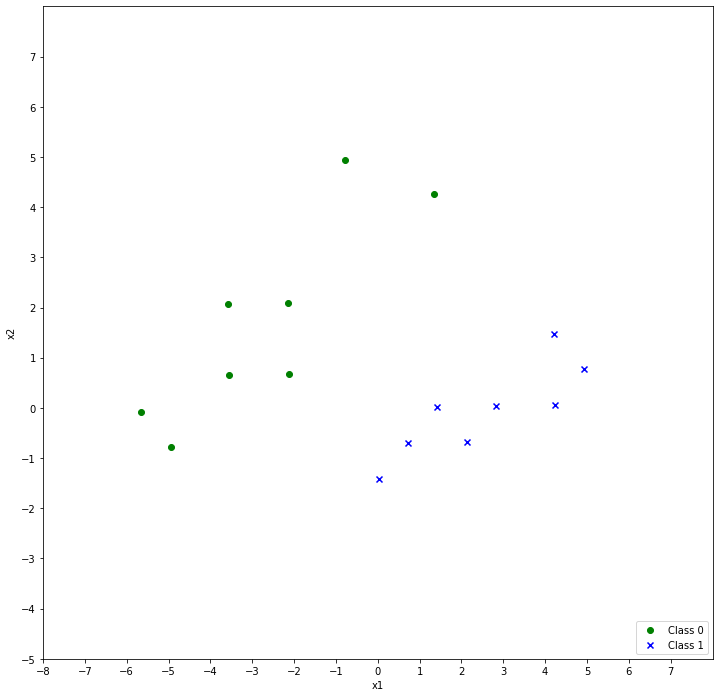

In [9]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

# Set plot limits
plt.xlim(-8, 8)
plt.ylim(-5, 8)

# Set axis ticks
plt.xticks(np.arange(-8, 8, step=1))
plt.yticks(np.arange(-5, 8, step=1))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()


## **a) Solve for the SVM with quadratic programming solver**

In [10]:
# N is the number of rows in the data matrix X
N = X.shape[0]

# Reshape y to match the shape of X
y = y.reshape((N,1))

# Create variables for the weights and bias
w = cp.Variable((2,1))
w0 = cp.Variable()

# Define the loss function as the L2 norm of w squared, which is equivalent to the L2 regularization
loss = cp.Minimize(0.5 * cp.square(cp.norm(w)))

# Create an empty list to store the constraints
constr = []

# Iterate through each data point and add a constraint for it
for i in range(N):
  xi, yi = X[i,:], y[i]
  constr += [yi @ (xi @ w + w0) >= 1]

# Create the optimization problem with the loss and constraints
prob = cp.Problem(loss, constr)

# Solve the problem
prob.solve()

# Print the values of the optimized variables
print(w.value, w0.value) # w = [1.0, -1.0], w0 = -1.0

[[ 0.47845723]
 [-0.46424468]] 0.33333333339392063


In [17]:
def classify(w, w0, X):
    n = len(X)
    predictions = np.zeros(n)
    for i in range(n):
        x1, x2 = X[i, 0], X[i, 1]
        class_found = (-w0.value - (w[0].value*x1))/w[1].value
        if(round(x2, 2) >= np.round(class_found, 2)):
            predictions[i] = 1
        else:
            predictions[i] = 0
    return predictions


##**b) Generating Plots**

The plot with the training samples, highlighting the support vectors and plotting the 2D decision curve

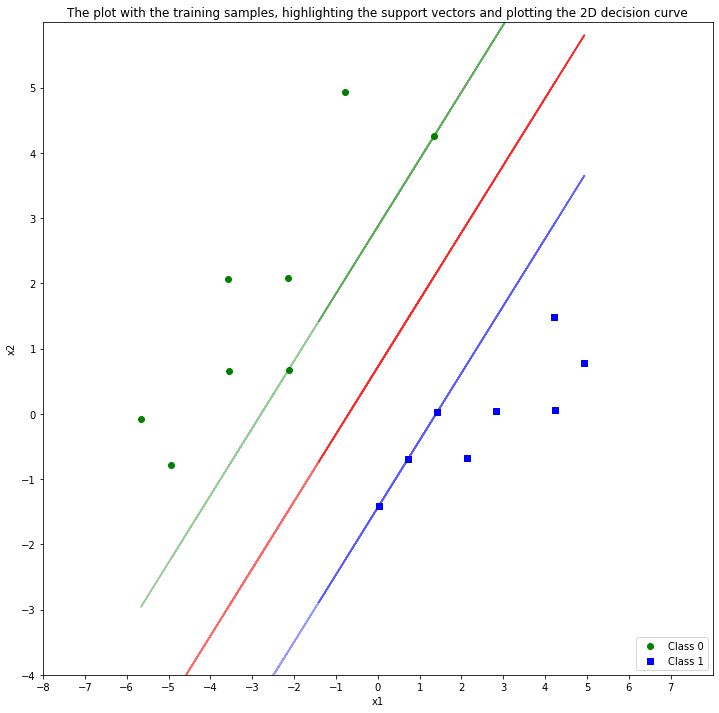

In [37]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='s', color='blue', 
            label='Class 1',)

# Plot the decision boundary and the margins using the optimized values of w and w0
plt.plot(X, (-w0.value - (w[0].value*X))/w[1].value , 'r', alpha=0.6)

# Plot the positive margin
plt.plot(X, (-w0.value - (w[0].value*X)+1)/w[1].value ,'b', alpha=0.4)

# Plot the negative margin
plt.plot(X, (-w0.value - (w[0].value*X)-1)/w[1].value , 'g', alpha=0.4)

# Set plot limits
plt.xlim(-8, 8)
plt.ylim(-4, 6)

# Set axis ticks
plt.xticks(np.arange(-8, 8, step=1))
plt.yticks(np.arange(-4, 6, step=1))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add legend
plt.legend(loc='lower right')

# Add title
plt.title("The plot with the training samples, highlighting the support vectors and plotting the 2D decision curve")

# Show plot
plt.show()


Classification Map

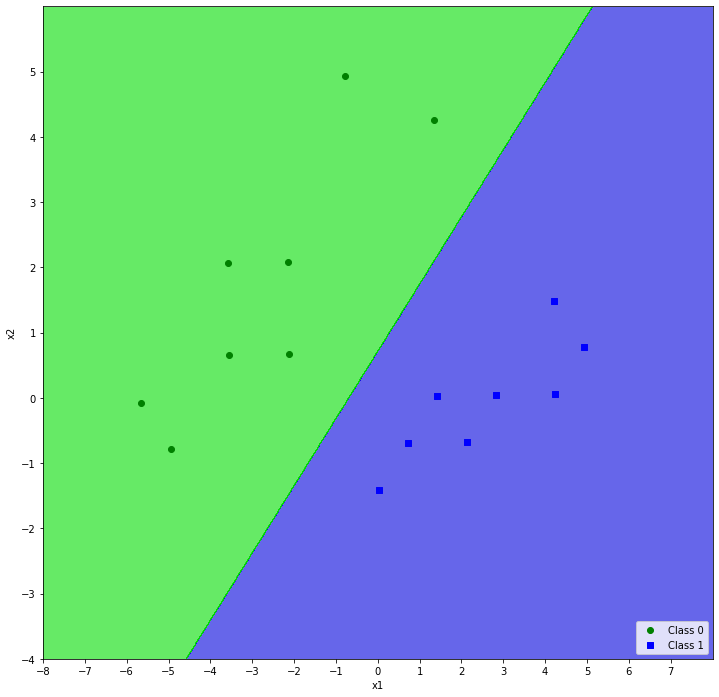

In [40]:
# Define step size for the mesh
h = 0.1

fig = plt.figure(figsize=(12, 12))

# Create a mesh to plot in
xx, yy = np.meshgrid(np.arange(-8, 8, h), np.arange(-4, 6, h))

# Plot the decision boundary using the classifier function
Z = classify(w, w0, np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
custom_map = ListedColormap(['#00DD', '#00DD00'])
plt.contourf(xx, yy, Z, cmap=custom_map, alpha=0.6)


# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='s', color='blue', 
            label='Class 1',)

# Set plot limits
plt.xlim(-8, 8)
plt.ylim(-4, 6)

# Set axis ticks
plt.xticks(np.arange(-8, 8, step=1))
plt.yticks(np.arange(-4, 6, step=1))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add title
plt.title("Classification Map")

# Add legend
plt.legend(loc='lower right')


plt.show()

## **c) Comparing the results with SVC**

In [12]:
from sklearn import svm
N = X.shape[0]
clf = svm.SVC(C = 1e16, kernel = 'linear')
clf.fit(X, y)
sv = clf.support_vectors_
w_svm = clf.coef_.flatten()
w0_svm = clf.intercept_
print(w_svm)
print(w0_svm) 

[ 0.47843938 -0.46434148]
[0.33342206]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


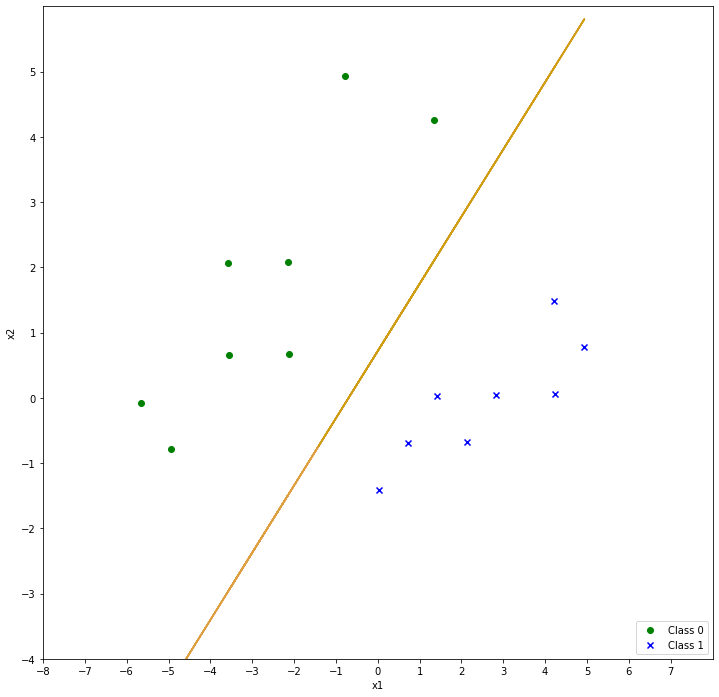

In [42]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

# Plot the decision boundary and the margins using the optimized values of w and w0
plt.plot(X, (-w0.value - (w[0].value*X))/w[1].value , 'r', alpha=0.5)
plt.plot(X, (-w0_svm - (w_svm[0]*X))/w_svm[1] , 'y', alpha=0.5)

# Set plot limits
plt.xlim(-8, 8)
plt.ylim(-4, 6)

# Set axis ticks
plt.xticks(np.arange(-8, 8, step=1))
plt.yticks(np.arange(-4, 6, step=1))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()


It is seen that both support vectors returned by SVC and the corresponding decision function are almost identical.

# **T2**

In [44]:
ds2.loc[ds2[2] == 0, 2] = -1

In [45]:
# Load the data and labels
X = ds2[[0,1]].values
y = ds2[2].values

In [ ]:
# Class 0 are negatives and Class 1 are positives
class_0 = ds2.loc[ds2[2] == -1]
class_1 = ds2.loc[ds2[2] == 1]

In [ ]:
X_neg = class_0[[0,1]].values
X_pos = class_1[[0,1]].values

y_pos = class_0[2].values
y_neg = class_1[2].values

In [ ]:
#Change classes to numpy
class_0 = class_0.to_numpy()
class_1 = class_1.to_numpy()

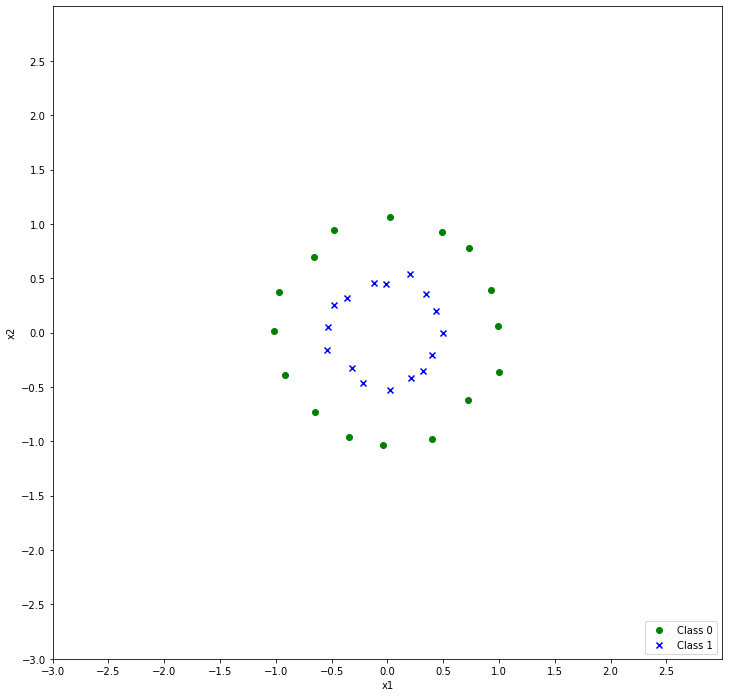

In [ ]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

# Set plot limits
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# Set axis ticks
plt.xticks(np.arange(-3, 3, step=0.5))
plt.yticks(np.arange(-3, 3, step=0.5))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()


In [51]:
N = X.shape[0]

# Reshape y to match the shape of X
y = y.reshape((N,1))

# Create variables for the weights and bias
w = cp.Variable((2,1))
w0 = cp.Variable()

# Define the loss function as the L2 norm of w squared, which is equivalent to the L2 regularization
loss = cp.Minimize(0.5 * cp.square(cp.norm(w)))

# Create an empty list to store the constraints
constr = []

# Iterate through each data point and add a constraint for it
for i in range(N):
  xi, yi = X[i,:], y[i]
  constr += [yi @ (xi @ w + w0) >= 1]

# Create the optimization problem with the loss and constraints
prob = cp.Problem(loss, constr)

# Solve the problem
prob.solve()

# Print the values of the optimized variables
print(w.value, w0.value) # w = [1.0, -1.0], w0 = -1.0


None None


In [52]:
def kernel(x, y):
  return (1 + np.dot(x, y.T)) ** 3

In [107]:
N = X.shape[0]

P = np.empty((N,  N))

for i in range(N):
		for j in range(N):
			P[i, j] = y[i]*y[j]*kernel(X[i], X[j])
   
q = -np.ones((N,1))
G = -np.eye(N)
h = np.zeros((N, 1))
A = y.reshape((1, N))
b = np.zeros((1, 1))

# Convert to CVXOPT matrix format
P = matrix(P)
q = matrix(q)
G = matrix(G)
h = matrix(h)
A = matrix(A.astype('double'))
b = matrix(b)

# Solve Optimization Problem
sol = solvers.qp(P, q, G, h, A, b)
lambdas = np.array(sol['x']).reshape(N)


     pcost       dcost       gap    pres   dres
 0: -2.5704e+00 -7.5354e+00  5e+01  6e+00  1e+00
 1: -1.0516e+00 -7.3379e+00  6e+00  1e-15  7e-16
 2: -2.5155e+00 -3.3408e+00  8e-01  4e-16  5e-16
 3: -2.8999e+00 -3.1904e+00  3e-01  3e-16  5e-16
 4: -3.0264e+00 -3.0623e+00  4e-02  6e-16  7e-16
 5: -3.0460e+00 -3.0471e+00  1e-03  4e-16  8e-16
 6: -3.0467e+00 -3.0468e+00  4e-05  3e-16  6e-16
 7: -3.0468e+00 -3.0468e+00  4e-07  5e-16  6e-16
Optimal solution found.


In [108]:
lambdas

array([5.70971723e-08, 1.80531919e-01, 1.66883889e-05, 2.04322048e-08,
       3.12441699e-08, 1.45180691e-08, 1.84746747e-08, 2.57313535e-08,
       7.48888174e-01, 1.94165148e-08, 6.29678150e-09, 1.24970092e+00,
       1.99041307e-08, 6.15667018e-01, 3.15257331e-08, 2.56155495e-08,
       1.91988995e-08, 3.29624488e-08, 1.58371335e-08, 1.18138387e+00,
       5.75180670e-01, 7.93981166e-09, 2.01513715e-08, 7.95648431e-08,
       5.95848775e-09, 2.58293512e-07, 5.49817681e-01, 1.53400570e-01,
       3.94075701e-08, 5.28927581e-08, 2.20836551e-08, 8.38916139e-01])

In [114]:
# Calculate b
SV = np.where(lambdas > 1e-8)[0][0]
b = y[SV] - sum(lambdas * y)
b

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
x_min = min(X[:, 0]) - 0.5
x_max = max(X[:, 0]) + 0.5
y_min = min(X[:, 1]) - 0.5
y_max = max(X[:, 1]) + 0.5
step = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
d = np.concatenate((xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)), axis=1)

Z = b + np.sum(
    lambdas.reshape((N, 1)) * y.reshape((N, 1)) * kernel(X, d),
    axis=0)
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax, palette='winter')
ax.contour(xx, yy, Z, levels=[-1, 0, 1])
fig.show()

In [ ]:
X1 = X_pos[:, 0].reshape((-1, 1))
X2 = X_pos[:, 1].reshape((-1, 1))
x1x2 = X1 * X2
x1x2sq = X1**2 + X2**2
X_pos = np.hstack((x1x2, x1x2sq))

In [ ]:
X1 = X_neg[:, 0].reshape((-1, 1))
X2 = X_neg[:, 1].reshape((-1, 1))
x1x2 = X1 * X2
x1x2sq = X1**2 + X2**2
X_neg = np.hstack((x1x2, x1x2sq))

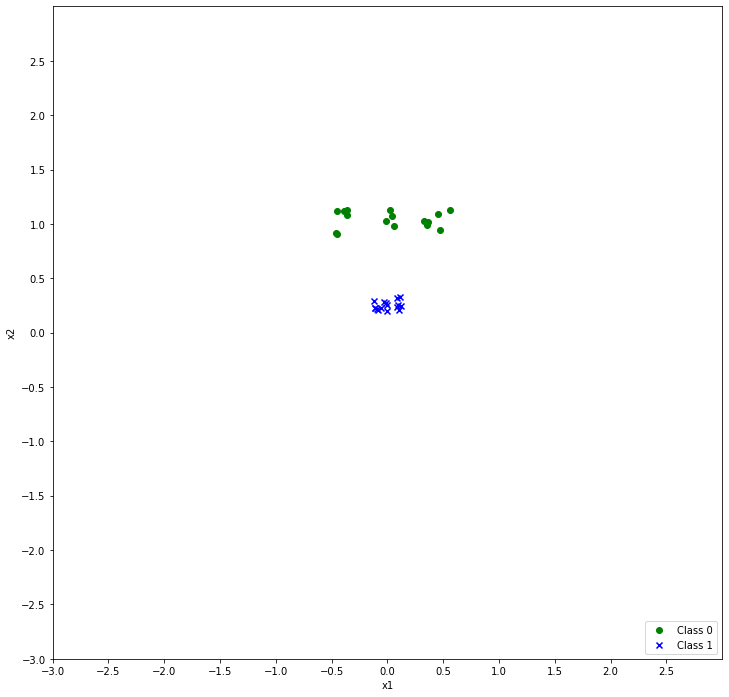

In [ ]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(X_neg[:, 0], X_neg[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(X_pos[:, 0], X_pos[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

# Set plot limits
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# Set axis ticks
plt.xticks(np.arange(-3, 3, step=0.5))
plt.yticks(np.arange(-3, 3, step=0.5))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()


In [ ]:
X1 = X[:, 0].reshape((-1, 1))
X2 = X[:, 1].reshape((-1, 1))
x1x2 = X1 * X2
x1x2sq = X1**2 + X2**2
X = np.hstack((x1x2, x1x2sq))

In [ ]:
# N is the number of rows in the data matrix X
N = X.shape[0]

# Reshape y to match the shape of X
y = y.reshape((N,1))

# Create variables for the weights and bias
w = cp.Variable((2,1))
w0 = cp.Variable()

# Define the loss function as the L2 norm of w squared, which is equivalent to the L2 regularization
loss = cp.Minimize(0.5 * cp.square(cp.norm(w)))

# Create an empty list to store the constraints
constr = []

# Iterate through each data point and add a constraint for it
for i in range(N):
  xi, yi = X[i,:], y[i]
  constr += [yi @ (xi @ w + w0) >= 1]

# Create the optimization problem with the loss and constraints
prob = cp.Problem(loss, constr)

# Solve the problem
prob.solve()

# Print the values of the optimized variables
print(w.value, w0.value) # w = [1.0, -1.0], w0 = -1.0

[[ 0.12358649]
 [-3.33103156]] 2.090755204584221


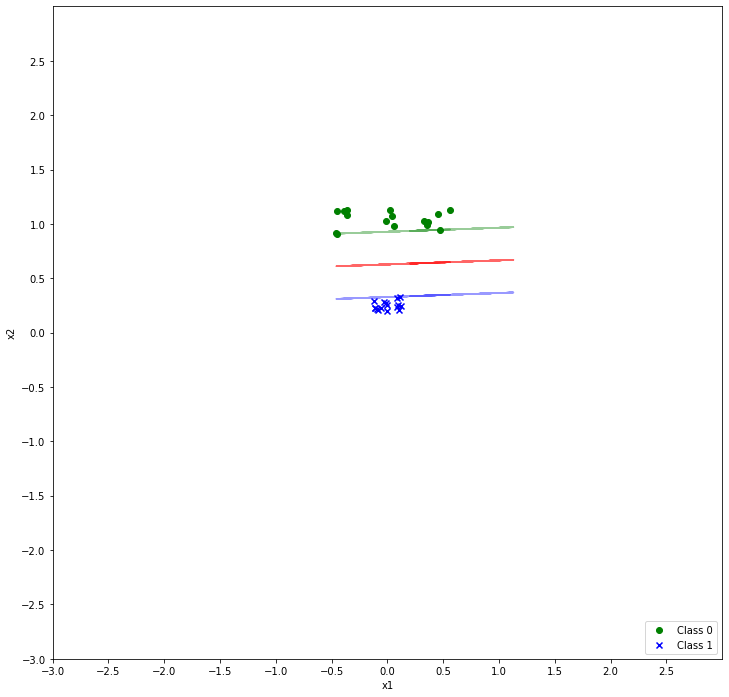

In [ ]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(X_neg[:, 0], X_neg[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(X_pos[:, 0], X_pos[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

# Plot the decision boundary and the margins using the optimized values of w and w0
plt.plot(X, (-w0.value - (w[0].value*X))/w[1].value , 'r', alpha=0.6)

# Plot the positive margin
plt.plot(X, (-w0.value - (w[0].value*X)+1)/w[1].value ,'b', alpha=0.4)

# Plot the negative margin
plt.plot(X, (-w0.value - (w[0].value*X)-1)/w[1].value , 'g', alpha=0.4)

# Set plot limits
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# Set axis ticks
plt.xticks(np.arange(-3, 3, step=0.5))
plt.yticks(np.arange(-3, 3, step=0.5))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()


# **T3**

In [ ]:
#Train and test
X_train = ds3tr.drop(columns=[2])
y_train = ds3tr[2]

X_test = ds3te.drop(columns=[2])
y_test = ds3te[2]

 hyper-parameters tuning

In [ ]:
knn = KNeighborsClassifier()
params = [{'n_neighbors': [3,5,7,9],'metric': ['euclidean', 'manhattan','cityblock','minkowski']}]

gs_knn = GridSearchCV(knn,
                      param_grid=params,
                      scoring='f1_weighted',
                      cv=5)
gs_knn.fit(X_train, y_train)
gs_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 7}

Best distance metric is manhattan and the best value for number og neighbors is 7

In [ ]:
knn = KNeighborsClassifier(metric='manhattan',n_neighbors=7)

In [ ]:
#Training the model
knn.fit(X_train, y_train)

#Predict test data set
y_pred = knn.predict(X_test)

#Checking performance our model with classification report
print(classification_report(y_test, y_pred))

#Checking performance our model with ROC Score
roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        32
         1.0       0.93      1.00      0.97        28

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



0.96875